## 1. importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api to  importstatistical models.
import os
import warnings # To handle warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings.
plt.style.use('fivethirtyeight') # A styling option for how plots will appear.

In [4]:
# configure API key

quandl.ApiConfig.api_key = '6Y-wwg1CAUSwB1PWqRxE'

## 2. Find a data set.

For this task I have chosen a dataset about the Consumer Price Index of the Housing Market in the US. There are not datasets related to my final projec in Quandl.

For more info visit the link: https://www.quandl.com/data/YALE/CPIA-Historical-Housing-Market-Data-Consumer-Price-Index-Annual

In [5]:
data = quandl.get('YALE/CPIA')

In [6]:
data.head(5)

,CPI
Date,
1890-12-31,7.611652
1891-12-31,7.801942
1892-12-31,7.326213
1893-12-31,7.897091
1894-12-31,6.850483


In [7]:
data.shape

(130, 1)

In [9]:
data.columns

Index(['CPI'], dtype='object')

In [10]:
type(data)

pandas.core.frame.DataFrame

In [11]:
# Plot the data using matplotlib

plt.figure(figsize=(15,5), dpi=100)

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

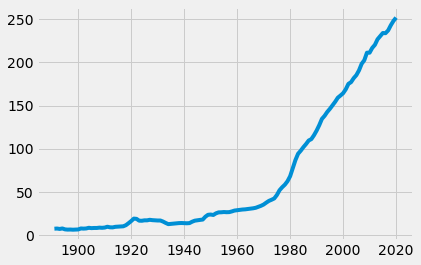

In [12]:
plt.plot(data)

## 3. Subsetting, wrangling, and cleaning tme-series data

Looking at the previous chart we can see that the biggest increase of the consumer price Index started in 1970. So  I want to analyze this index from the moment that increase started and until data was collected.
To be able to do that I will create a subset with data from 1970 to 2019.

In [13]:
# First I reset the index to be able to use the "Date" column as filter

data_2 = data.reset_index()

In [15]:
data_2.head()

,Date,CPI
0,1890-12-31,7.611652
1,1891-12-31,7.801942
2,1892-12-31,7.326213
3,1893-12-31,7.897091
4,1894-12-31,6.850483


In [25]:
# Second, I create a new data_sub using te "loc" function and the "Date" column

data_sub = data_2.loc[(data_2['Date'] >= '1970-12-31') & (data_2['Date'] < '2020-12-31')]

In [26]:
data_sub.shape

(50, 2)

In [28]:
data_sub.head()

,Date,CPI
80,1970-12-31,37.8
81,1971-12-31,39.8
82,1972-12-31,41.1
83,1973-12-31,42.6
84,1974-12-31,46.6


In [29]:
# Set the "Date"column as the index
from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()


,CPI
datetime,
1970-12-31,37.8
1971-12-31,39.8
1972-12-31,41.1
1973-12-31,42.6
1974-12-31,46.6


## 4.Create a line chart of new data

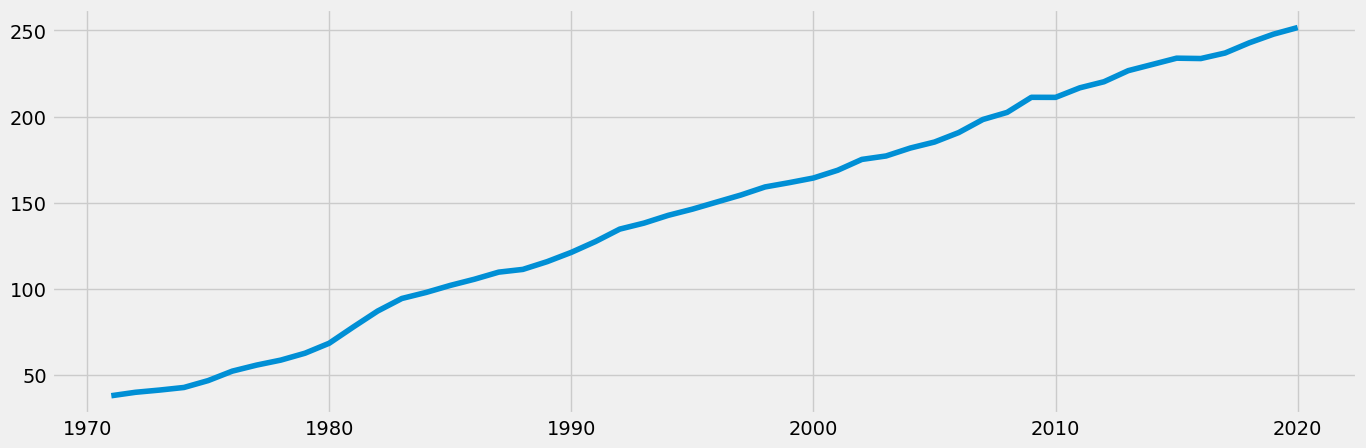

In [30]:
# Let's have a look at the new dataframe's chart

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [31]:
# Check for missing values and duplicates

In [32]:
data_sub.isnull().sum()

CPI    0
dtype: int64

In [33]:
dups = data_sub.duplicated()
dups.sum()

0

## 5. Decomposing the data's components

In [34]:
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [35]:
from pylab import rcParams # To define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

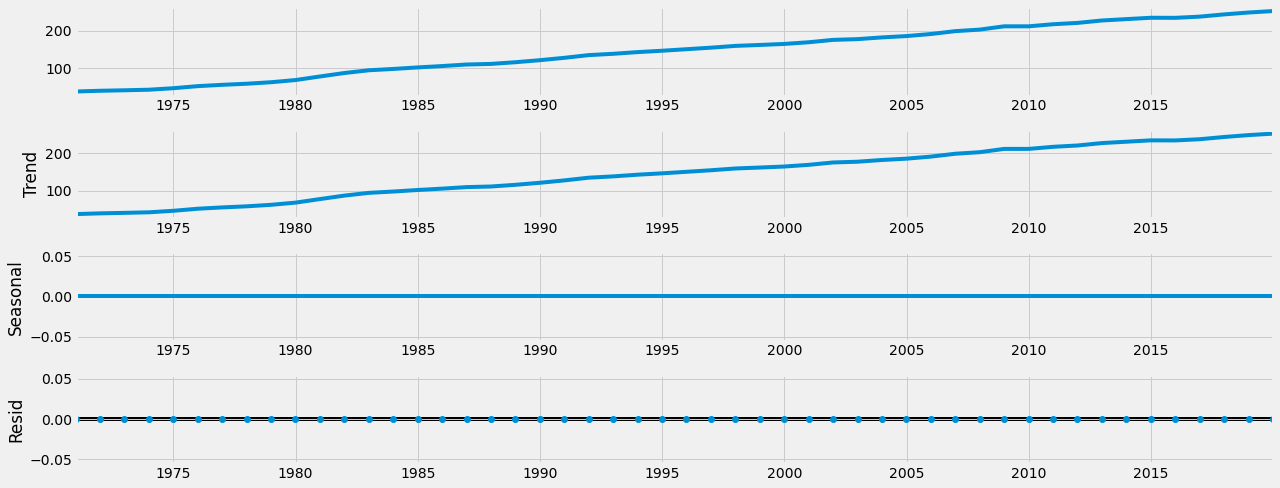

In [36]:
# Plot the separate components

decomposition.plot()
plt.show()

On the decomposed charts first, we observe the data itself (level). The second chart is the underlying trend and in this case the data has no noise (smooth data) therefore level and trend look the same.

The third chart shows the seasonality of the data and in this case as data is presented only once a year we don't appreciate any seasonality and therefore the curve is flat.

Finally, the last chart is the noise or "residual" data. Anything else that can affect a time series. In this case we can't appreciate anything but a series of dots representing each year data was published.

## 6. Conduct a Dickey_Fuller test to check for stationarity

In [38]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller 

# Define the function
def dickey_fuller(timeseries): 

# Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['CPI'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.221192
p-value                         0.664413
Number of Lags Used             3.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


When comparing the "Test Statistic" value with the "Critical Value"we can see the former is larger than the latter so I couldn't reject the null hypothesis. This means that there is a unit root in this data and that it is non-stationary.

Also the p-value is bigger that 0.05 therefroe this is not a "significant" result.


## 7. As data isn't stationary, we conduct a round of differencing

In [39]:
# I calculate the difference between every value (t) and its lag(t-1)

data_diff = data_sub - data_sub.shift(1)

In [43]:
# I remove the missing values that came about as a result of the differencing

data_diff.dropna(inplace = True)

In [44]:
data_diff.head()

,CPI
datetime,
1971-12-31,2.0
1972-12-31,1.3
1973-12-31,1.5
1974-12-31,4.0
1975-12-31,5.5


In [45]:
data_diff.columns

Index(['CPI'], dtype='object')

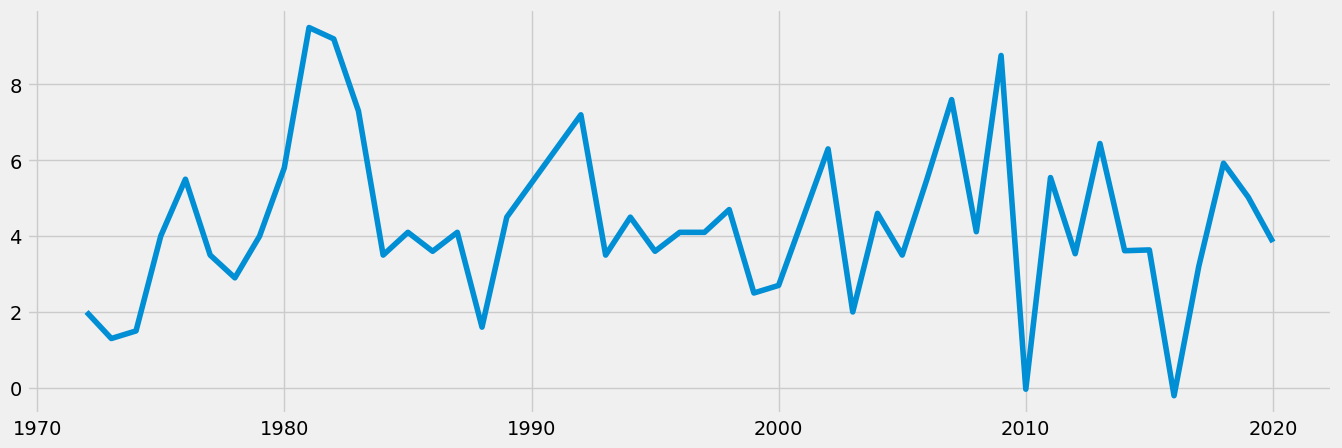

In [46]:
# Create a new chart to see the effect of differencing
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [47]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.977276
p-value                         0.000025
Number of Lags Used             2.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


After performing the differencing technique we can see that now the test statistic is smaller than the critical value at 1, 5 and 10 percent. Also the satisfactory p-value is smaller than 0.05 therefore I can reejct the null hypothesis and consider these series stationary.

## 9. Check data for autocorrelations

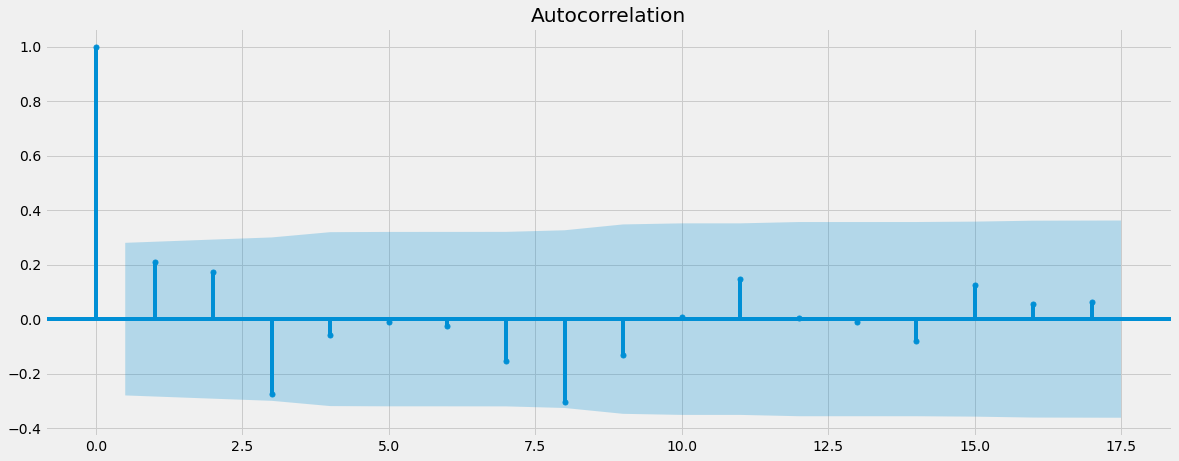

In [48]:
# Import plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# create chart
plot_acf(data_diff)
plt.show()

All the lags in the serias but one (1970 as this is the first value of the dataset and doesn't have a lag) are within the blue area which represents the confidence interval. This means that there is only one autocorrelated term, as it s the first one of the data, and that the data is now stationary.